# Hands-On Dask Basics *for NVTabular Developers*

**Author**: Rick Zamora (rzamora@nvidia.com)

**Date**: Preparted July 10th 2020 (last update 7/10/2020)

**Acknowledgement**: Much of the introductory material included here is borrowed from other Dask documentation and tutorials.  For example, parts of this notebook are taken directly from Jacob Tomlinson's recent ["Dask Video Tutorial"](https://github.com/jacobtomlinson/dask-video-tutorial-2020) ([YouTube link](https://www.youtube.com/watch?v=_u0OQm9qf_A)).


**Note**: The target of this tutorial/introduction is **NVTabular** developers.  This means I will focus on the components of Dask that are most critical for NVTabular.  There is a lot more to Dask than the simple examples and use cases covered in this tutorial.

<img src='images/dask-horizontal.svg' width=400>

## What is Dask

**Very Short Answer**: [Dask](https://dask.org/) is an open-source library designed to natively scale Python code.

**Slightly-Longer Short Answer**: Dask is a task-based library for parallel scheduling and execution. Although it is certainly possible to use the task-scheduling machinary directly to implement customized parallel workflows (we do in NVTabular), most users only interact with Dask through a *Dask Collection API*.  The most popular "collection" API's include:

- [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html): Dask-based version of the [Pandas](https://pandas.pydata.org/) DataFrame/Series API.  Note that `dask_cudf` is just a wrapper around this collection module (`dask.dataframe`).
- [Dask Array](https://docs.dask.org/en/latest/array.html): Dask-based version of the [NumPy]() array API
- [Dask Bag](https://docs.dask.org/en/latest/bag.html): *Similar to* a Dask-based version of PyToolz or a Pythonic version of PySpark RDD


For example, Dask DataFrame provides a convenient API for decomposing large pandas (or cuDF) DataFrame/Series objects into a collection of DataFrame *partitions*.  This tutorial will focus mostly on this particular Dask collection (since it is the basis for `dask_cudf`).  However, instead of relying only on the established `dask.dataframe` API, we will also see how it is possible (perhaps easy) to implement a custom task graph to operate on Dask-DataFrame objects when necessary.

<img src="images/dask-dataframe.svg" width="350px">

### Dask Uses DAGs Internally

Before we start writing any code, it is useful to understand (on a basic level) how Dask actully works. When an application or library uses a Dask collection API (like Dask DataFrame), they are typically using that API to construct a directed acyclic graph (DAG) of tasks.  Once a DAG is constructed, the **core** Dask API can be used (either directly or implicitly through the collection API) to schedule and execute the DAG on one or more threads/processes.

In other words, Dask provides various APIs to:

1. Construct a DAG of "tasks"
2. Schedule/execute those DAGs
3. (Optionally) Spin up dedicated worker and scheduler processes to enable distributed execution

<img src='images/dask_dag_cartoon.png' width=500>

### Important Components of the "Dask Ecosystem"

The components of the Dask ecosystem that are most critical for NVTabular (and will be discussed in this tutorial) are:

- `dask` (core Dask library): [[GitHub Repo](https://github.com/dask/dask)]  This is the core Dask library.  It also contains the Dask Dataframe API (`dask.dataframe`)
- `dask_cudf`: [[GitHub Repo](https://github.com/rapidsai/cudf/tree/branch-0.15/python/dask_cudf)] This is effectively a wrapper around the `dask.dataframe` module defined in the core Dask library.  Note that a `dask_cudf.DataFrame` object should be thought of as a `dask.dataframe.DataFrame` object, but with the underlying partitions being `cudf.DataFrame`'s (rather than `pandas.DataFrame`)
- `distributed`: [[GitHub Repo](https://github.com/dask/distributed)] Distributed version of the Dask execution model (includes the necessary code for scheduling, execution and communication between distributed processes).  This library does not deal with the construction of DAGs, just with the scheduling and execution of DAGs on distributed *workers*.
- `dask_cuda`: [[GitHub Repo](https://github.com/rapidsai/dask-cuda)] Provides various utilities to improve deployment and management of distributed Dask *workers* on CUDA-enabled systems.

## Hands On: Dask DataFrame Code

Let's start by exploring the (pandas-like) Dask DataFrame API using a toy dataset. Although Dask is typically used in conjunction with a distributed cluster in production, we will start by using the (default) single-machine approach here...

In [18]:
import dask.dataframe as dd

ddf = dd.read_csv('data/beer_small.csv', blocksize=12e6)
ddf

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
npartitions=2,,,,,,,,,,,,,,
,int64,int64,object,int64,float64,float64,float64,object,object,float64,float64,object,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Here we have created a `dask.dataframe.DataFrame` object called `ddf`.  `ddf` is essentiually a (**lazy**) collection of pandas dataframes.  Each pandas dataframe in this collection is called a **partition**.  In this example, we only have **two** partitions.  We can access this property (the total number of partitions) using the `DataFrame.npartitions` attribute.

**It is absolutely critical to recognize that `ddf` is *not* actually backed by *in-memory* pandas data, but instead by a DAG of tasks**.  This DAG (accessible via `ddf.dask`) specifies the exact network of operations needed to preduce the underlying partitions.

In [2]:
# At this point, `ddf.dask` will correspond to a `HighLevelGraph` object.

print(ddf.dask, "\n")
print(ddf.dask.layers, "\n")


{'read-csv-1b3e81cbee82801f8774e69b9a605a59': <dask.dataframe.io.csv.CSVSubgraph object at 0x7f2712c07310>} 



At this point, the `ddf.dask` DAG will correspond to a `HighLevelGraph` object. The purpose of that class is to enable various "high-level graph optimizations" before the scheduler ultimately converts the graph (back) into a dictionary of key-argument tuples.

Besides comprising a list of (pandas) partitions and an underlying DAG, a `dask.dataframe.DataFrame` object also includes (among other things) a public `divisions` attribute and a private `_meta` attribute.

- `divisions`: Specifies the "threshold" index values between adjacent partitions.  If there is a global (sorted) index, Dask can use these divisions (if known) to speed up certain operations. Although we do not set/use this attribute in NVTabular (at the moment), it is good to be aware of.
- `_meta`: An empty `pandas.DataFrame` object used to define the global schema (column/index names and dtypes) for the Dask DataFrame.  Since a Dask DataFrame is lazily evaluated, the class will use this `_meta` attribute as a proxy object to determine how each task will transform the schema of the larger collection.

In [3]:
# Inspect the `_meta` attribute

print(type(ddf._meta))
ddf._meta

<class 'pandas.core.frame.DataFrame'>


,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


__Processing Data with Pandas Syntax__

A key feature of Dask DataFrame is its close mapping to the Pandas API. For example, if we want to filter `ddf` to include "IPA"-style beers, we can do so with familiar syntax...

In [4]:
ddf = ddf[ddf.beer_style.str.contains('IPA')]

We can also do things like: select a subset of columns, add a new column, sort according to overall review, and reset the index...

In [19]:
ddf = ddf[["brewery_name", "review_overall", "beer_style"]]
ddf["100_scale"] = (ddf["review_overall"] / 5.0 * 100).astype("int")
ddf = ddf.set_index("review_overall", shuffle="tasks").reset_index(drop=True)

Under the hood, these operations are simply adding tasks to the `ddf` DAG, and updating the `_meta` attribute...

In [20]:
ddf._meta

,brewery_name,beer_style,100_scale


__Executing the `ddf` DAG__

Note that we still haven't loaded any data into memory at this point. The `ddf` object still corresponds to a DAG (and other light-weight metadata). If we want to actually execute the task graph, and load the data into memory, we can use `ddf.compute()`

> **Important Information about `compute`**: The `compute` method is [defined for all Dask collections](https://github.com/dask/dask/blob/51d3f1120fc55f21b5ce1ac137201ea01d9cf496/dask/base.py#L143). For Dask DataFrame, this method will (1) trigger the execution of the graph and (2) convert the Dask DataFrame into a **single** Pandas DataFrame. *This means that you shuold be sure the pandas equivalent of `ddf` will fit in memory before you use `compute`!*

When running in the default single-machine mode (which we are doing here), you can also specify the type of scheduler you want to use to execute the graph. The options are: `"threads"`, `"synchronous"` or `"processes"`.  When debugging dask code, I highly recommend you use the `"synchronous"`, because it effectively serializes all execution (allowing you to use `pdb` in a reliable way)...

In [21]:
ddf.compute(scheduler="synchronous")

,brewery_name,beer_style,100_scale
0,Dogfish Head Brewery,American Double / Imperial IPA,20
1,Nøgne Ø - Det Kompromissløse Bryggeri A/S,American Double / Imperial Stout,20
2,Anheuser-Busch,Herbed / Spiced Beer,20
3,Lang Creek Brewery,Winter Warmer,20
4,Dogfish Head Brewery,American Barleywine,20
...,...,...,...
130271,Victory Brewing Company,American Barleywine,100
130272,Flying Dog Brewery,Witbier,100
130273,Surly Brewing Company,American Brown Ale,100
130274,Der HirschBrau/Privatbrauerei Höss,Hefeweizen,100


__Using `persist`__

Since the `compute` method will convert your Dask DataFrame to a Pandas DataFrame, it is typically a **bad** idea to use compute on larger-than-memory (LTM) datasets.  In NVTabular, we do use a `compute` method, but never on a full Dask/dask_cudf DataFrame object.  Instead, we use `compute` to trigger the collection/reduction of an aggregated statistics dictionary, and/or to write out a processed dataset.

In order to execute the `ddf` DAG **without** converting it to a single pandas DataFrame, you need to use the [`persist` method](https://github.com/dask/dask/blob/51d3f1120fc55f21b5ce1ac137201ea01d9cf496/dask/base.py#L101). This function is particularly useful when using distributed systems, because the results will be kept in distributed memory, rather than returned to the local process as with compute. It will also allow the distributed cluster to clean up data that the scheduler no longer deems necessary.  For the single-machine case, the method is used less often.

__Visualizing the DAG__

Dask makes it very easy to visualize the task graph of a collection using the [`visualize` method](https://docs.dask.org/en/latest/api.html#dask.visualize).  To use this utility, you will need to install the `graphviz` library...

E.g. `conda install -c conda-forge python-graphviz`

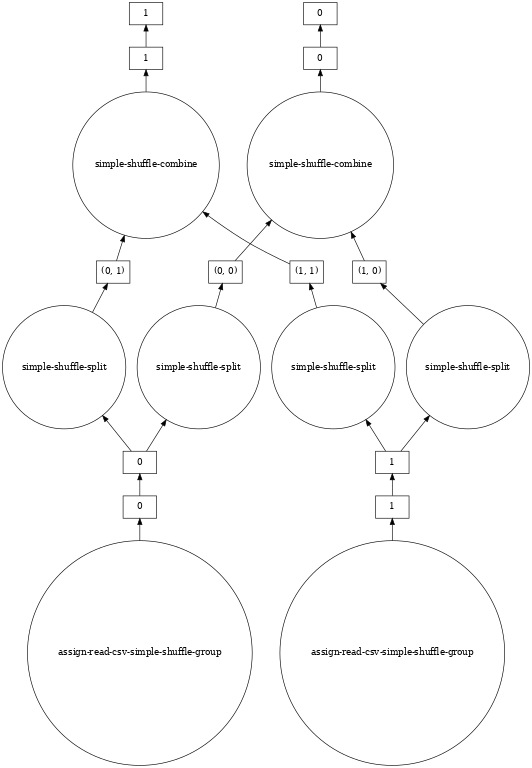

In [23]:
ddf.visualize(optimize_graph=True, verbose=False, size="8")

## Hands On: *Custom Graph (No DataFrame API)*

Now that we know the absolute basics of the Dask DataFrame (which is the foundation of dask_cudf), we will take a temporary step away from this high-level API and focus on low-level DAG construction.

The good news is that a Dask task graph is just a python dictionary of key-argument tuples!

Before we try to implement a custom task graph on a Dask DataFrame, we will start with something similar to the [simple example](https://docs.dask.org/en/latest/custom-graphs.html) available in the Dask documentation.

In [31]:
import numpy as np
import pandas as pd

part_size = 5
nparts = 3

def gen(i):
    return pd.Series(np.random.randint(1000, size=part_size))

def modify(s):
    mean = s.mean()
    return s - mean

def combine(sequence_of_data):
    df = pd.DataFrame()
    for i, data in enumerate(sequence_of_data):
        df[str(i)] = data
    return df

dsk = {}
for i in range(nparts):
    dsk["gen-"+str(i)] = (gen, i)
    dsk["modify-"+str(i)] = (modify, "gen-"+str(i))
dsk["combine"] = (combine, ['modify-%d' % i for i in range(nparts)])
dsk

{'gen-0': (<function __main__.gen(i)>, 0),
 'modify-0': (<function __main__.modify(s)>, 'gen-0'),
 'gen-1': (<function __main__.gen(i)>, 1),
 'modify-1': (<function __main__.modify(s)>, 'gen-1'),
 'gen-2': (<function __main__.gen(i)>, 2),
 'modify-2': (<function __main__.modify(s)>, 'gen-2'),
 'combine': (<function __main__.combine(sequence_of_data)>,
  ['modify-0', 'modify-1', 'modify-2'])}

Note that the anatomy of the `dsk` DAG is very simple:

- `dsk` is a python `dict`
- Each element in `dsk` corresponds to a task
- Each task has a unique key (which is also the `dict` key)
- The content (value) of each task is represented as a `tuple`.
    - The first element of this `tuple` is typically a *callable* function
    - The remaining elements of this `tuple` are typically the function arguments
    - One or more of the function arguments can be the key of a different task (defining an edge in the DAG)
    - A function argument can also be a list of multiple task keys (common for tree reductions)
    
As we did for `ddf` above, we can also visualize `dsk` with `graphviz`...

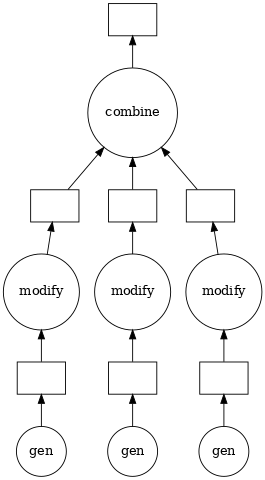

In [38]:
from dask import visualize
visualize(dsk, optimize_graph=True, verbose=False, size="5")

When we are ready to execute our custom graph, we can access the result of a specific task using the `get` function (and by passing the graph and the key of the desired task output)...

In [39]:
from dask.threaded import get
get(dsk, "combine")

,0,1,2
0,-171.8,254.6,-396.4
1,186.2,-289.4,124.6
2,-71.8,-40.4,204.6
3,273.2,-429.4,-27.4
4,-215.8,504.6,94.6
